In [ ]:
# COCO 2017 데이터셋을 활용한 CNN-Attention 하이브리드 모델 for Image Captioning
# 학습 목표 : 이미지 캡션 생성을 위한 CNN-Attention 하이브리드 모델 구현 목표

# CNN-Attention 하이브리드 이미지 캡셔닝 학습 팁
#- Encoder : 이미지 → CNN으로 특징 추출 (ResNet-50 → [batch_size, 14×14, 2048] 공간 특징 유지)
#- Decoder : 이미지 특징 → Attention으로 시퀀스 생성 (이미지의 각 위치에 대한 attention + 캡션 시퀀스)
#- 문장 생성 방식 : 매 시점마다 이미지의 다른 위치에 집중하며 단어 생성
#- 표현력 : 객체, 배경, 위치 등 세부 정보 및 자연스럽고 정확한 문장 생성 가능
#- 시각화 : 각 단어가 이미지의 어느 부분을 보고 생성됐는지 시각화 가능 (attention map)

# 학습 데이터셋: MS COCO 추천
#- 손실 함수: nn.CrossEntropyLoss()
#- 옵티마이저: torch.optim.Adam
# MS COCO 데이터셋은 이미지와 캡션이 포함되어 있음

# 추천 학습 흐름
#- 데이터 로더 구성 → 완료
#- 캡션 토큰화 및 임베딩 처리
#- CNN-Attention 모델 구성
#- 학습 루프 구현 (Loss, Optimizer)
#- 검증 및 예측 결과 시각화
#- 성능 분석 및 개선 시도

# 핵심 차이: "어디를 보고 말하는가?"
#- 기존 모델은 이미지 전체를 한 번에 요약해서 디코더에 넘긴다
#  (마치 사진을 한 번 보고 기억으로 문장을 만드는 느낌)
#- Attention 모델은 문장을 생성할 때마다 이미지의 다른 위치를 다시 본다
#  (마치 사진을 계속 보면서 "곰 얼굴", "잔디", "침대" 등 필요한 부분에 집중하는 느낌)

In [ ]:
# 필요한 라이브러리 설치
# pip install pycocotools nltk pillow

In [2]:
# 1) 필요한 라이브러리 임포트

# import 문보다 먼저 실행되어야 한다, 이미지 로딩 속도 개선(PIL보다 빠른 백엔드)
# from torchvision import set_image_backend
# set_image_backend('accimage')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence # 배치 16이면 16개 배치중에 가장 긴 문장에 맞추고 나머지 짧은 문장은 0 (<PAD>)으로 패딩 처리
import nltk
# COCO (Common Objects in Context), - Microsoft에서 만든 대규모 이미지 데이터셋으로, 
# 이미지에 대한 객체 바운딩 박스, 분할 마스크, 캡션 등의 다양한 주석(annotation)을 포함
# COCO 데이터셋의 JSON 주석 파일을 쉽게 파싱하고 다룰 수 있도록 만든 Python 라이브러리입니다.
from pycocotools.coco import COCO
from collections import Counter
import os, zipfile, shutil
import pickle
from PIL import Image
import matplotlib.pyplot as plt

nltk.download('punkt')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Pytorch Version: {torch.__version__},  device: {DEVICE}")

Using Pytorch Version: 2.7.1+cu118,  device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# 데이터 및 폴더가 많아서 별도로 폴더 삭제 및 압축 풀기 코드 분리함
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/coco/train2017'):
    shutil.rmtree('./data/coco/train2017')
    print('./data/coco/train2017 is removed')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/annotations_trainval2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/annotations_trainval2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/annotations_trainval2017.zip')
    with zipfile.ZipFile('./data/coco/annotations_trainval2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/annotations_trainval2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/val2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/val2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/val2017.zip')
    with zipfile.ZipFile('./data/coco/val2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/val2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/test2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/test2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/test2017.zip')
    with zipfile.ZipFile('./data/coco/test2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/test2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/train2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/train2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/train2017.zip')
    with zipfile.ZipFile('./data/coco/train2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/train2017.zip')

In [3]:
# 2) Vocabulary 클래스 정의
import re

class Vocabulary:
    def __init__(self, freq_threshold=5): # 초기화
        self.freq_threshold = freq_threshold # 단어가 등장한 횟수가 이 값 이상일 때만 사전에 포함
        self.word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3} # 단어 → 인덱스 매핑. 특수 토큰 4개는 항상 포함
        self.idx2word = {0:'<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'} # 인덱스 → 단어 매핑. 위와 동일하게 초기화
        self.word_freq = Counter() # 단어 빈도수를 저장하는  객체
        self.idx = 4 # 새로운 단어 인덱스는 4부터 시작 (특수 토큰 이후) - <PAD>, <SOS>, <EOS>, <UNK> 이후 단어 인덱스 시작

    def tokenizer(self, text): # 문장 -> 토큰 리스트
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)  # 부호 제거로 단순화

        return nltk.tokenize.word_tokenize(text.lower()) # 입력 문장을 소문자로 변환한 뒤, NLTK의 로 단어 단위로 분리, - 예: "A man riding a horse." → ['a', 'man', 'riding', 'a', 'horse', '.']

    def build_vocabulary(self, sentence_list): # 단어 사전 구축
        for sentence in sentence_list: # 전체 캡션 리스트 (예: COCO에서 추출한 모든 캡션)
            tokens = self.tokenizer(sentence) # 각 문장을 토큰화
            self.word_freq.update(tokens) # Counter() 객체인 self.word_freq에 각 단어의 등장 횟수를 누적

        for word, freq in self.word_freq.items(): # 누적된 단어 빈도수를 순회하면서 사전에 포함할 단어를 결정
            if freq >= self.freq_threshold: # 단어 빈도가 기준치 이상인 경우
                self.word2idx[word] = self.idx # 단어 → 인덱스 매핑에 추가
                self.idx2word[self.idx] = word # 인덱스 → 단어 매핑에 추가
                self.idx += 1 # 다음 인덱스로 증가

    def numericalize(self, text): # 리스트 형태의 숫자 시퀀스를 반환
        tokens = self.tokenizer(text) # 입력된 문장을 소문자로 바꾸고, NLTK의 를 사용해 단어 단위로 분리
        
        # 1. 각 토큰을 self.word2idx.get()은 word2idx 사전을 통해 숫자 인덱스로 변환, 
        # 2. .get(token, self.word2idx['<UNK>'])는 해당 단어가 word2idx 사전에 없으면 <UNK> 인덱스(기본값 3)를 반환
        # 예시) word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3, 'a':4, 'man':5, 'riding':6, 'horse':7}
        # 예시) tokens = ['a', 'man', 'riding', 'a', 'horse', '.']
        # 예시) numericalized = [4, 5, 6, 4, 7, 3]  # '.'은 사전에 없으므로 <UNK>로 처리
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

In [4]:
# 3) coco 캡션 로딩 및 단어 사전 구축
vocab_path = './data/vocab.pkl'

if os.path.exists(vocab_path):
    # 저장된 vocab 불러오기
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    print(f'Vocabulary loaded from {vocab_path}, size: {len(vocab.word2idx)}')

else:
    # Vocabulary 새로 생성 및 저장
    # 캡션 사전 구축
    raw_coco = COCO('./data/coco/annotations/captions_train2017.json') # 캡션 JSON 파일을 파싱해서 COCO 객체 생성
    all_captions = [ann['caption'] for ann in raw_coco.anns.values()] # 모든 캡션(annotation) 딕셔너리 접근에서 'caption' 값만 추출하여 리스트로 생성
    vocab = Vocabulary(freq_threshold=5) # 단어 빈도수 기준 2 이상인 단어만 사전에 포함
    vocab.build_vocabulary(all_captions) # 캡션 리스트로부터 단어 사전 구축 - 단어->인덱스, 인덱스->단어 매핑 생성

    # 단어 사전 저장
    # - 추론 시 generate_caption_text()에서 단어 ↔ 인덱스 변환
    # - Streamlit 웹앱에서 모델과 함께 로드
    # - BLEU 평가 시 정답 캡션 비교에 사용
    with open('./data/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)
    print(f'Vocabulary built and saved to {vocab_path}, size: {len(vocab.word2idx)}')


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Vocabulary built and saved to ./data/vocab.pkl, size: 10192


In [5]:
# 4) COCO Dataset 클래스 정의
import random

class CocoDataset(Dataset):
    def __init__(self, root, annotation, vocab, transform=None):
        self.root = root # 이미지가 저장된 폴더 경로 (train2017, val2017 등)
        self.coco = COCO(annotation) # COCO 캡션(이미지 설명) JSON 파일 경로 (captions_train2017.json)
        # self.ids = list(self.coco.imgToAnns.keys()) # 이미지 ID 리스트(pycocotools를 통해 캡션 JSON을 파싱한 COCO 객체)
        MAX_IMAGES = 60000
        self.ids = list(self.coco.imgToAnns.keys())[:MAX_IMAGES] # 예: 상위 5,000장만 사용
        self.transform = transform # 이미지 전처리 함수
        self.vocab = vocab # Vocabulary 객체

    def __getitem__(self, index): # 이미지와 캡션 하나를 불러와 텐서로 반환
        img_id = self.ids[index] # 현재 인덱스에 해당하는 이미지 ID
        ann_ids = self.coco.getAnnIds(imgIds=img_id) # 해당 이미지에 연결된 캡션 ID들
        captions = self.coco.loadAnns(ann_ids) # 캡션 내용들 (여러 개일 수 있음) 로드
        # caption = captions[0]['caption'] # 여러 캡션 중 첫 번째 캡션 선택, COCO는 이미지당 여러 캡션이 있지만, 여기서는 하나만 선택하며 추후 평균 BLEU 평가 시 여러 개를 사용할 수도 있음
        caption = random.choice(captions)['caption']  # 이미지당 여러 캡션 중 랜덤으로 선택 선택
        path = self.coco.loadImgs(img_id)[0]['file_name'] # 이미지 파일 이름 로드
        image = Image.open(os.path.join(self.root, path)).convert('RGB') # 이미지 열기 및 RGB 변환
        if self.transform is not None: # 이미지 전처리 함수가 지정된 경우
            image = self.transform(image) # 이미지 전처리 적용

        # 입력 캡션) caption = "a man riding a horse."
        # Vocabulary 사전) self.vocab.word2idx = {
        #        '<SOS>': 1,
        #        '<EOS>': 2,
        #        '<UNK>': 3,
        #        '<PAD>': 0,
        #        'a': 4,
        #        'man': 5,
        #        'riding': 6,
        #        'horse': 7
        #    }
        # 토큰화 결과) tokens = ['a', 'man', 'riding', 'a', 'horse', '.'], 
        # - '.'은 사전에 없으므로 <UNK>로 처리
        # 숫자 시퀀스(numericalize) numericalized = [4, 5, 6, 4, 7, 3]
        # 최종 텐서) caption_tensor = torch.tensor([1, 4, 5, 6, 4, 7, 3, 2], dtype=torch.long)
        caption_tensor = torch.tensor( # 캡션 텐서 생성 - 문장 시작 <SOS>와 종료 <EOS> 토큰을 앞뒤에 붙임
            [self.vocab.word2idx['<SOS>']] +
            self.vocab.numericalize(caption) +
            [self.vocab.word2idx['<EOS>']],
            dtype=torch.long
        )

        # 이미지, 캡션 -> 텐서로 변환하여 EncoderCNN, DecoderRNN 각 모델에 입력으로 들어감
        # image [C, H, W] = [3, 224, 224], caption_tensor [seq_len] = [단어 인덱스 시퀀스 길이]
        return image, caption_tensor

    def __len__(self): # 데이터셋 크기 반환
        return len(self.ids)

In [6]:
# 5) Collate 함수 정의
def collate_fn(batch):
    # Dataset에서 반환된 image, caption_tensor 쌍들 - batch는 [(image1, caption1), (image2, caption2), ...] 형태
    # zip(*batch)를 사용하면 이미지와 캡션을 각각 튜플로 분리, - images: (image1, image2, ...), - captions: (caption1, caption2, ...)
    images, captions = zip(*batch)
    # 이미지 텐서들을 배치 차원으로 쌓기 - 각 이미지 텐서 [3, 224, 224] -> stack [batch_size, 3, 224, 224]로 배치 구성
    images = torch.stack(images)

    # 배치 16이면 16개 배치중에 가장 긴 문장에 맞추고 나머지 짧은 문장은 0 (<PAD>)으로 패딩 처리
    # caption1 = [1, 4, 5, 2]  길이 4,   caption2 = [1, 6, 7, 8, 2]  길이 5
    # → 패딩 후: [[1, 4, 5, 2, 0], [1, 6, 7, 8, 2]]
    # 캡션은 길이가 다르기 때문에 가장 긴 캡션에 맞춰 나머지를 0 (<PAD>)으로 패딩, 
    # batch_first=True → 결과 텐서의 shape이 [batch_size, max_seq_len]이 되도록 설정
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    # images: [batch_size, 3, 224, 224] 모델의 CNN 인코더에 입력될 이미지 배치, 
    # captions: [batch_size, max_seq_len] 모델의 RNN 디코더에 입력될 시퀀스 배치
    return images, captions

In [7]:
# 6) 데이터 전처리 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),              # 먼저 크게 리사이즈
    transforms.RandomCrop((224, 224)),          # 랜덤 크롭으로 다양한 시야 확보
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전 (50% 확률)
    transforms.ColorJitter(brightness=0.2,      # 밝기, 대비, 채도, 색상 변형
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet 사전학습 모델 표준화 값
                         std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 데이터셋
train_dataset = CocoDataset( # 이미지와 캡션 데이터셋 객체 생성 - 이미지와 캡션을 불러오고, 캡션을 인덱스 시퀀스로 변환
    root='./data/coco/train2017', # 이미지 폴더 경로
    annotation='./data/coco/annotations/captions_train2017.json', # 캡션 JSON 파일 경로
    vocab=vocab, # 위에서 만든 단어 사전
    transform=transform # 이미지 전처리 함수
)

val_dataset = CocoDataset(
    root='./data/coco/val2017',  # 검증 이미지 폴더
    annotation='./data/coco/annotations/captions_val2017.json',  # 검증 캡션 JSON
    vocab=vocab,
    transform=val_transform
)

# 데이터로더
train_loader = DataLoader(
    train_dataset, # 데이터셋 객체
    batch_size=32, # 배치 크기 - 실제 학습에는 16 ~ 32 개의 이미지-캡션 쌍을 불러옴. 단 초기 프로토타입 실험과 시각화, 디버깅을 안정적으로 진행하기 위함
    shuffle=True, # 셔플 여부 - epoch마다 데이터를 섞어서 학습
    collate_fn=collate_fn, # Collate 함수 지정 - pad_sequence()를 사용해 캡션을 패딩하고, [batch_size, max_seq_len] 텐서로 만듭니다.
    num_workers=0,  # CPU 코어 절반 사용
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  # 검증은 셔플하지 않음
    collate_fn=collate_fn,
    num_workers=0,  # CPU 코어 절반 사용
    pin_memory=True
)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


⏱️ 배치 로딩 시간: 1.04초


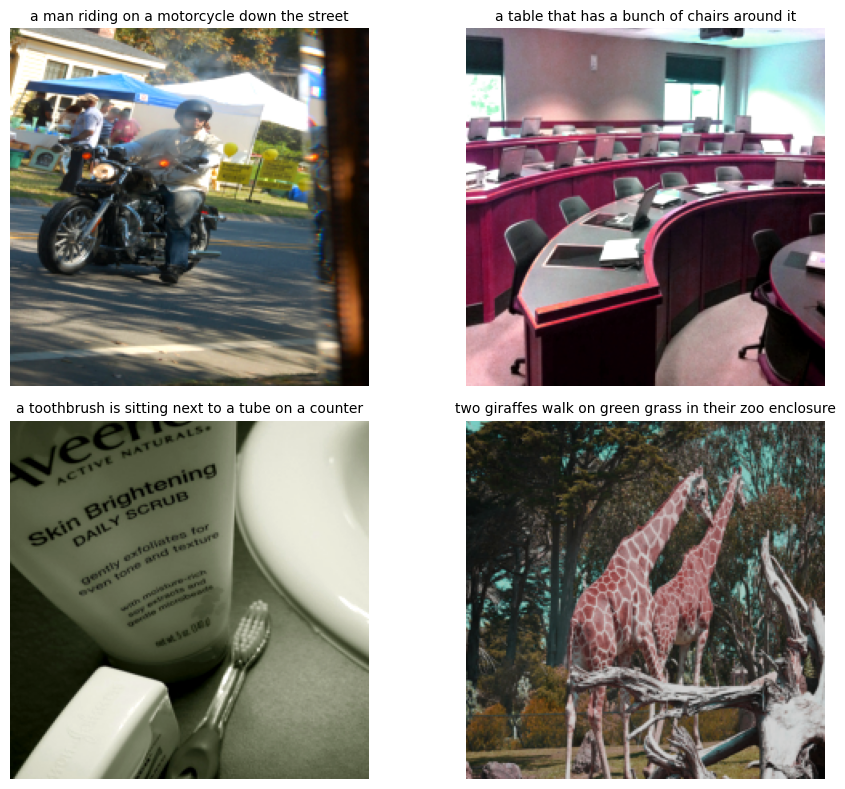

In [8]:
# 7) 샘플 시각화
import matplotlib.pyplot as plt
import time
start = time.time()
images, captions = next(iter(train_loader))
print(f"⏱️ 배치 로딩 시간: {time.time() - start:.2f}초")

# Normalize 역변환용 텐서
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

# 2x2 subplot으로 한 번에 시각화
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0).cpu()
    img = img * std + mean
    img = img.clamp(0, 1)

    caption = [vocab.idx2word[idx.item()] for idx in captions[i] if idx.item() not in [0, 1, 2]]
    axes[i].imshow(img)
    axes[i].set_title(' '.join(caption), fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
caption json :  {'image_id': 391895, 'id': 770337, 'caption': 'A man with a red helmet on a small moped on a dirt road. '}
image id :  391895
image_id :  391895
caption :  A man with a red helmet on a small moped on a dirt road. 


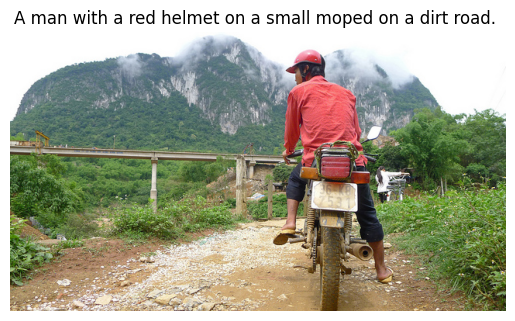

In [9]:
# 캡션 객체 로딩 및 세부내용 확인용 

# 캡션 json 파일
annotation_file = './data/coco/annotations/captions_train2017.json'

# coco 객체 생성
coco = COCO(annotation_file=annotation_file)

# 이미지 id 리스트 가져오기
image_ids = list(coco.imgs.keys())

# 첫번째 이미지 id로 캡션 확인
first_img_id = image_ids[0]
ann_ids = coco.getAnnIds(imgIds=first_img_id)
annotations = coco.loadAnns(ann_ids)

# 첫번째 캡션 출력
print('caption json : ', annotations[0])
print('image id : ', first_img_id)
print('image_id : ', annotations[0]['image_id'])
print('caption : ', annotations[0]['caption'])

# 이미지 폴더 경로
image_dir = './data/coco/train2017'

# 이미지 파일 이름 가져오기
image_info = coco.loadImgs(first_img_id)[0]
file_name = image_info['file_name']

# 전체 이미지 경로
image_path = os.path.join(image_dir, file_name)

# 이미지 열기
image = Image.open(image_path).convert('RGB')

# 이미지 시각화
plt.imshow(image)
plt.axis('off')
plt.title(annotations[0])
plt.title(annotations[0]['caption'])
plt.show()

In [132]:
# 8) Encoder-Decoder 모델 정의

# 이미지 특징 추출기
class EncoderCNN(nn.Module): # Pretrained Model ResNet-50을 사용해 이미지에서 공간적 특징 맵 추출
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # pretrained model ResNet-50
        modules = list(resnet.children())[:-2] # 두 계층을 제거 - avgpool, fc(fully connected)
        self.resnet = nn.Sequential(*modules) # 일부 계층을 선택적으로 구성해서 새로운 네트워크로 만든다
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)) # 특징 맵을 고정된 크기(14x14)로 변환

    def forward(self, images):
        features = self.resnet(images)                      # [batch_size, 2048, H, W]
        features = self.adaptive_pool(features)             # [batch_size, 2048, 14, 14]
        features = features.permute(0, 2, 3, 1)             # [batch_size, 14, 14, 2048]
        return features.view(features.size(0), -1, features.size(-1))  # [batch_size, 196, 2048] -> 이렇게 펼친 후 Attention과 Decoder에 전달

# 시각적 초점 조절
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim) # 이미지 특징(2048차원) -> attention 공간
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) # 디코더 hidden(512차원) -> attention 공간
        self.full_att = nn.Linear(attention_dim, 1) # attention 점수 계산용 선형 계층
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # 위치별로 확률 분포 생성

    # encoder_out=[batch_size, num_pixels, encoder_dim], decoder_hidden=[batch_size, decoder_dim]
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)                     # [batch_size, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)     # [batch_size, 1, attention_dim], 모양을 맞추기 위함
        att = self.relu(att1 + att2)                             # [batch_size, num_pixels, attention_dim], 두 attention 벡터를 더하고 ReLU 적용
        alpha = self.softmax(self.full_att(att))                 # [batch_size, num_pixels, 1], 196개 이미지 위치별에 대한 attention 가중치 값
        context = (encoder_out * alpha).sum(dim=1)               # [batch_size, encoder_dim], 이미지 특징에 attention 가중치 곱해서 계산
        return context, alpha # context 디코더 입력용 요약 벡터, alpha 196개 이미지 위치별에 대한 attention 가중치 값

# 이미지 캡셔닝 모델의 문장 생성기
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim) # Attention 모듈 초기화: 이미지 특징과 디코더 hidden state 받아 context vector 생성, alpha attention 가중치 생성

        self.embedding = nn.Embedding(vocab_size, embed_dim) # 단어 인덱스를 받아서 임베딩 벡터로 변화(512차원)
        self.dropout = nn.Dropout(p=dropout) # 과적합 방지
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True) # 단어 임베딩과 context vector 입력으로 받아 다음 hidden state 생성

        self.init_h = nn.Linear(encoder_dim, decoder_dim) # 이미지 특징의 평균을 이용해 LSTM의 초기 hidden state h 설정
        self.init_c = nn.Linear(encoder_dim, decoder_dim) # 이미지 특징의 평균을 이용해 LSTM의 초기 cell state c 설정
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) # attention gate: context vector에 얼마나 집중할지 조절하는 게이트
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size) # LSTM 출력 [batch_size, vocab_size] 크기의 로짓 점수 -> 단어 분포로 변환(softmax는 학습 루프에서 CrossEntropyLoss로 처리)
    
    def init_hidden_state(self, encoder_out):
        """
        encoder_out: [batch_size, num_pixels, encoder_dim]
        encoder_out의 평균을 이용해 LSTM 초기 hidden state와 cell state를 생성
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # [batch_size, encoder_dim]
        h = self.init_h(mean_encoder_out)           # [batch_size, decoder_dim]
        c = self.init_c(mean_encoder_out)           # [batch_size, decoder_dim]
        return h, c


    def forward(self, encoder_out, encoded_captions, caption_lengths):
        device = encoder_out.device
        batch_size = encoder_out.size(0)
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)  # [batch_size, num_pixels, encoder_dim]
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_idx = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        h = self.init_h(encoder_out.mean(dim=1))  # [batch_size, decoder_dim]
        c = self.init_c(encoder_out.mean(dim=1))  # [batch_size, decoder_dim]

        embeddings = self.embedding(encoded_captions)  # [batch_size, max_len, embed_dim]
        max_len = caption_lengths.max().item()

        predictions = torch.zeros(batch_size, max_len, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max_len, num_pixels).to(device)

        for t in range(max_len):
            batch_size_t = (caption_lengths > t).sum().item()
            context, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            context = gate * context

            lstm_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1)
            h, c = self.decode_step(lstm_input, (h[:batch_size_t], c[:batch_size_t]))

            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha.squeeze(2)

        return predictions, alphas
    
    def generate_caption(self, encoder_out, vocab, max_length=20):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)

        # Flatten encoder output: [batch_size, num_pixels, encoder_dim]
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)

        # Initialize LSTM states
        h, c = self.init_hidden_state(encoder_out)

        # Start with <SOS> token
        word = torch.tensor([vocab.word2idx["<SOS>"]]).to(encoder_out.device)
        embeddings = self.embedding(word)  # [1, embed_dim]

        caption = []
        attention_weights = []

        for _ in range(max_length):
            # Attention 모듈이 (context, alpha) 반환됨 (forward와 동일하게)
            context, alpha = self.attention(encoder_out, h)  # context: [batch, encoder_dim], alpha: [batch, num_pixels, 1] 또는 [batch, num_pixels]

            # alpha 차원 정규화
            if alpha.dim() == 3:
                alpha = alpha.squeeze(2)  # [batch_size, num_pixels]

            # context 차원 보장
            if context.dim() == 3:
                context = context.squeeze(1)  # 안전장치 (대부분 [batch, encoder_dim])

            # embeddings 차원 보장
            if embeddings.dim() == 1:
                embeddings = embeddings.unsqueeze(0)  # [batch_size, embed_dim]

            # (선택) attention gate 적용: forward와 일관성 유지
            gate = self.sigmoid(self.f_beta(h))       # [batch_size, encoder_dim]
            context = gate * context                  # [batch_size, encoder_dim]

            # LSTM 입력: 단어 임베딩 + context 벡터
            lstm_input = torch.cat([embeddings, context], dim=1)  # [batch_size, embed_dim + encoder_dim]
            h, c = self.decode_step(lstm_input, (h, c))

            # 다음 단어 예측
            output = self.fc(self.dropout(h))
            predicted = output.argmax(1)
            word = predicted
            embeddings = self.embedding(word)  # [batch_size, embed_dim]

            # 단어와 attention 기록
            word_str = vocab.idx2word[word.item()]
            caption.append(word_str)
            attention_weights.append(alpha)  # [batch_size, num_pixels]

            # <EOS> 나오면 종료
            if word_str == "<EOS>":
                break

        return caption, attention_weights
    
    def generate_caption_beam_search(self, encoder_out, vocab, beam_size=3, max_length=20):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)

        # Flatten encoder output: [batch_size, num_pixels, encoder_dim]
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)

        # Initialize hidden states
        h, c = self.init_hidden_state(encoder_out)

        # Beam size만큼 hidden state 확장
        h = h.expand(beam_size, -1)  # [beam_size, decoder_dim]
        c = c.expand(beam_size, -1)  # [beam_size, decoder_dim]

        # Beam search 변수 초기화
        k = beam_size
        vocab_size = len(vocab.word2idx)

        # 시작 토큰 <SOS>
        seqs = torch.LongTensor([[vocab.word2idx["<SOS>"]]] * k).to(encoder_out.device)
        top_k_scores = torch.zeros(k, 1).to(encoder_out.device)

        complete_seqs = []
        complete_seqs_scores = []

        # encoder_out도 beam_size만큼 확장
        encoder_out = encoder_out.expand(k, encoder_out.size(1), encoder_out.size(2))

        for _ in range(max_length):
            embeddings = self.embedding(seqs[:, -1])  # [k, embed_dim]

            # Attention
            context, alpha = self.attention(encoder_out, h)
            if context.dim() == 3:
                context = context.squeeze(1)

            gate = self.sigmoid(self.f_beta(h))
            context = gate * context

            # LSTM 입력
            lstm_input = torch.cat([embeddings, context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))

            # 다음 단어 확률
            scores = self.fc(h)  # [k, vocab_size]
            scores = torch.log_softmax(scores, dim=1)

            # 누적 점수 업데이트
            scores = top_k_scores.expand_as(scores) + scores

            # 상위 k 단어 선택
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

            prev_word_inds = top_k_words // vocab_size
            next_word_inds = top_k_words % vocab_size

            # 시퀀스 업데이트
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

            # 종료 조건 (<EOS> 토큰 확인)
            incomplete_inds = [ind for ind, word in enumerate(next_word_inds) if word != vocab.word2idx["<EOS>"]]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # 완성된 시퀀스 저장
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
                k -= len(complete_inds)

            if k == 0:
                break

            # 남은 beam만 유지
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)

        # 최종 선택 (fallback 포함)
        if len(complete_seqs_scores) == 0:
            # fallback: 아직 살아있는 beam 중 최고 점수 선택
            i = top_k_scores.argmax().item()
            seq = seqs[i].tolist()
        else:
            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]

        # 인덱스를 단어로 변환 + 특수 토큰 제거
        caption = [vocab.idx2word[idx] for idx in seq]
        caption = [w for w in caption if w not in ["<SOS>", "<EOS>", "<PAD>"]]
        return caption


In [133]:
# 9) 모델 하이퍼파라미터 설정 및 모델,손실함수,옵티마저 객체 생성
# 하이퍼파라미터
embed_dim = 768         # 단어 임베딩 차원
decoder_dim = 768       # 디코더 LSTM hidden state 차원
encoder_dim = 2048      # CNN 인코더 출력 차원 (예: ResNet-101)
attention_dim = 768     # 어텐션 내부 차원
dropout = 0.5           # 드롭아웃 비율
learning_rate = 1e-4    # 학습률

# 인코더: CNN 기반 (예: ResNet)
encoder = EncoderCNN().to(DEVICE)

# 디코더: 어텐션 기반 LSTM
decoder = DecoderWithAttention(
    attention_dim=attention_dim,
    embed_dim=embed_dim,
    decoder_dim=decoder_dim,
    vocab_size=len(vocab.word2idx),
    encoder_dim=encoder_dim,
    dropout=dropout
).to(DEVICE)

# 손실함수 정의
# criterion = nn.CrossEntropyLoss()
pad_idx = vocab.word2idx['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# 옵티마이저는 학습 가능한 파라미터만 사용
encoder_optimizer = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, encoder.parameters()),
    lr=learning_rate
)

decoder_optimizer = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, decoder.parameters()),
    lr=learning_rate
)

print(encoder)
print(decoder)

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [12]:
# 10) EarlyStopping 클래스 구현
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience            # 개선 없을 때 기다릴 epoch 수
        self.min_delta = min_delta          # 개선으로 인정할 최소 변화량
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def step(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

In [13]:
# 11) 학습 루프
import time
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_idx = vocab.word2idx["<PAD>"]

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
scaler = GradScaler()
early_stopper = EarlyStopping(patience=5, min_delta=0.001)

best_val_loss = float('inf')
num_epochs = 30

# ✅ Loss 기록용 리스트
train_losses = []
val_losses = []
early_stop_epoch = None  # EarlyStopping 발동 시점 기록

# 🔒 초기에는 Encoder freeze → Decoder만 학습
for param in encoder.resnet.parameters():
    param.requires_grad = False

# ✅ Optimizer: 처음에는 Decoder만
optimizer = torch.optim.Adam(
    decoder.parameters(),
    lr=1e-4
)

for epoch in range(num_epochs):
    # -------------------- Fine-tuning 전환 --------------------
    if epoch == 1:  # 2번째 epoch부터 Encoder도 학습
        print("🔓 Fine-tuning 시작: Encoder도 학습에 포함됩니다.")
        for param in encoder.resnet.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam([
            {'params': decoder.parameters(), 'lr': 1e-4},   # Decoder 학습률
            {'params': encoder.parameters(), 'lr': 1e-5}    # Encoder 학습률 (더 작게)
        ])

    encoder.train()
    decoder.train()
    total_train_loss = 0
    start_time = time.time()

    # -------------------- Training Loop --------------------
    for i, (images, captions) in enumerate(train_loader):
        images, captions = images.to(DEVICE), captions.to(DEVICE)
        caption_lengths = (captions != pad_idx).sum(dim=1)

        with autocast():
            encoder_out = encoder(images)
            outputs, alphas = decoder(encoder_out, captions, caption_lengths)

            targets = captions[:, 1:]       # <SOS> 제외
            outputs = outputs[:, :-1, :]    # 마지막 <EOS> 제외

            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            targets = targets.contiguous().view(-1)

            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"[Train] Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    # -------------------- Validation Loop --------------------
    encoder.eval()
    decoder.eval()
    total_val_loss = 0

    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(DEVICE), captions.to(DEVICE)
            caption_lengths = (captions != pad_idx).sum(dim=1)

            with autocast():
                encoder_out = encoder(images)
                outputs, alphas = decoder(encoder_out, captions, caption_lengths)

                targets = captions[:, 1:]
                outputs = outputs[:, :-1, :]

                outputs = outputs.contiguous().view(-1, outputs.size(-1))
                targets = targets.contiguous().view(-1)

                val_loss = criterion(outputs, targets)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # ✅ Loss 기록
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # -------------------- EarlyStopping & Save --------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(decoder.state_dict(), "best_decoder.pt")
        torch.save(encoder.state_dict(), "best_encoder.pt")
        print(f"💾 모델 저장됨 - 개선된 Val Loss: {avg_val_loss:.4f}")

    early_stopper.step(avg_val_loss)
    if early_stopper.early_stop:
        early_stop_epoch = epoch + 1   # ✅ EarlyStopping 발동 epoch 기록
        print(f"⏹ Early stopping triggered at epoch {epoch+1}")
        
        break

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] 완료 - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, 소요 시간: {elapsed:.2f}초")

C:\Users\AI\AppData\Local\Temp\ipykernel_20488\2008145623.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\AI\AppData\Local\Temp\ipykernel_20488\2008145623.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Train] Epoch 1, Batch 10/1875, Loss: 9.0836
[Train] Epoch 1, Batch 20/1875, Loss: 8.8224
[Train] Epoch 1, Batch 30/1875, Loss: 8.6513
[Train] Epoch 1, Batch 40/1875, Loss: 8.2903
[Train] Epoch 1, Batch 50/1875, Loss: 7.6704
[Train] Epoch 1, Batch 60/1875, Loss: 7.1825
[Train] Epoch 1, Batch 70/1875, Loss: 6.9270
[Train] Epoch 1, Batch 80/1875, Loss: 6.8821
[Train] Epoch 1, Batch 90/1875, Loss: 6.0327
[Train] Epoch 1, Batch 100/1875, Loss: 6.4671
[Train] Epoch 1, Batch 110/1875, Loss: 6.1165
[Train] Epoch 1, Batch 120/1875, Loss: 6.2168
[Train] Epoch 1, Batch 130/1875, Loss: 6.1393
[Train] Epoch 1, Batch 140/1875, Loss: 5.9424
[Train] Epoch 1, Batch 150/1875, Loss: 5.8482
[Train] Epoch 1, Batch 160/1875, Loss: 5.9557
[Train] Epoch 1, Batch 170/1875, Loss: 5.9438
[Train] Epoch 1, Batch 180/1875, Loss: 5.5334
[Train] Epoch 1, Batch 190/1875, Loss: 5.9780
[Train] Epoch 1, Batch 200/1875, Loss: 5.8338
[Train] Epoch 1, Batch 210/1875, Loss: 5.8173
[Train] Epoch 1, Batch 220/1875, Loss: 5.83

C:\Users\AI\AppData\Local\Temp\ipykernel_20488\2008145623.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


💾 모델 저장됨 - 개선된 Val Loss: 5.3542
Epoch [1/30] 완료 - Train Loss: 5.6166, Val Loss: 5.3542, 소요 시간: 1714.60초
🔓 Fine-tuning 시작: Encoder도 학습에 포함됩니다.
[Train] Epoch 2, Batch 10/1875, Loss: 5.1806
[Train] Epoch 2, Batch 20/1875, Loss: 5.3984
[Train] Epoch 2, Batch 30/1875, Loss: 5.6309
[Train] Epoch 2, Batch 40/1875, Loss: 5.3486
[Train] Epoch 2, Batch 50/1875, Loss: 5.3307
[Train] Epoch 2, Batch 60/1875, Loss: 5.0885
[Train] Epoch 2, Batch 70/1875, Loss: 4.9235
[Train] Epoch 2, Batch 80/1875, Loss: 5.4513
[Train] Epoch 2, Batch 90/1875, Loss: 5.7194
[Train] Epoch 2, Batch 100/1875, Loss: 5.5980
[Train] Epoch 2, Batch 110/1875, Loss: 5.1748
[Train] Epoch 2, Batch 120/1875, Loss: 5.5493
[Train] Epoch 2, Batch 130/1875, Loss: 5.4218
[Train] Epoch 2, Batch 140/1875, Loss: 5.1519
[Train] Epoch 2, Batch 150/1875, Loss: 5.1589
[Train] Epoch 2, Batch 160/1875, Loss: 5.5139
[Train] Epoch 2, Batch 170/1875, Loss: 5.2117
[Train] Epoch 2, Batch 180/1875, Loss: 5.5184
[Train] Epoch 2, Batch 190/1875, Loss: 

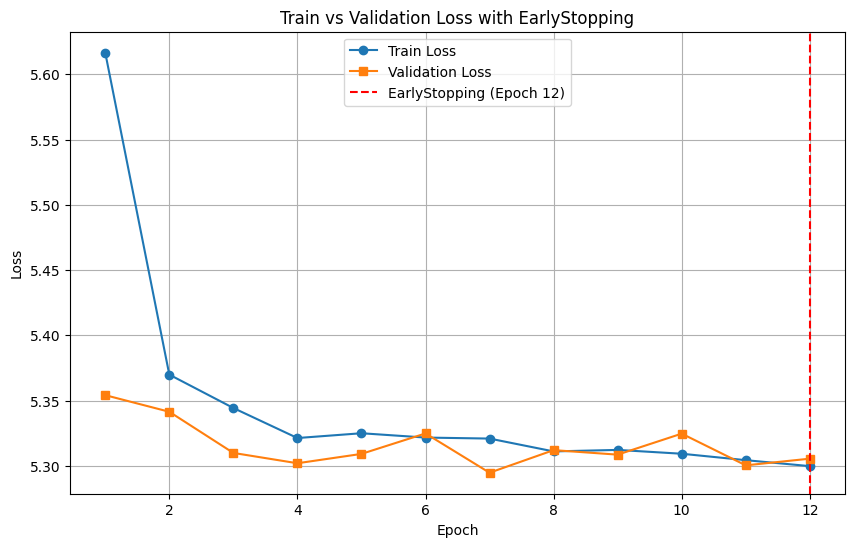

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')

# ✅ EarlyStopping 시점 표시
if early_stop_epoch is not None:
    plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label=f'EarlyStopping (Epoch {early_stop_epoch})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss with EarlyStopping')
plt.legend()
plt.grid(True)
plt.show()


In [134]:
# 14) 모델 저장
import os

# 저장 폴더 생성
os.makedirs('./models', exist_ok=True)

# 모델 저장
torch.save(encoder.state_dict(), './models/encoder_hybrid_coco.pt')
torch.save(decoder.state_dict(), './models/decoder_hybrid_coco.pt')

print("📦 모델 저장 완료: encoder_hybrid_coco.pt, decoder_hybrid_coco.pt")

📦 모델 저장 완료: encoder_hybrid_coco.pt, decoder_hybrid_coco.pt


In [135]:
# 15) 모델 로드
# 모델 구조 먼저 정의한 후
encoder.load_state_dict(torch.load('./models/encoder_hybrid_coco.pt', map_location=DEVICE))
decoder.load_state_dict(torch.load('./models/decoder_hybrid_coco.pt', map_location=DEVICE))

encoder.to(DEVICE)
decoder.to(DEVICE)
encoder.eval()
decoder.eval()

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=768, bias=True)
    (decoder_att): Linear(in_features=768, out_features=768, bias=True)
    (full_att): Linear(in_features=768, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(10192, 768)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2816, 768)
  (init_h): Linear(in_features=2048, out_features=768, bias=True)
  (init_c): Linear(in_features=2048, out_features=768, bias=True)
  (f_beta): Linear(in_features=768, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=768, out_features=10192, bias=True)
)

In [108]:
print(vocab.word2idx["<SOS>"])
print(vocab.word2idx["<EOS>"])
print(vocab.idx2word[0])  # <PAD>인지 확인


1
2
<PAD>


In [112]:
idx2word_list = [None] * len(vocab.word2idx)
for word, idx in vocab.word2idx.items():
    idx2word_list[idx] = word

print(idx2word_list[:10])

print("<SOS>:", vocab.word2idx.get("<SOS>"))
print("<EOS>:", vocab.word2idx.get("<EOS>"))


encoder.load_state_dict(torch.load("best_encoder.pt"))
decoder.load_state_dict(torch.load("best_decoder.pt"))
encoder.eval()
decoder.eval()


['<PAD>', '<SOS>', '<EOS>', '<UNK>', 'a', 'bicycle', 'replica', 'with', 'clock', 'as']
<SOS>: 1
<EOS>: 2


DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=768, bias=True)
    (decoder_att): Linear(in_features=768, out_features=768, bias=True)
    (full_att): Linear(in_features=768, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(10192, 768)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2816, 768)
  (init_h): Linear(in_features=2048, out_features=768, bias=True)
  (init_c): Linear(in_features=2048, out_features=768, bias=True)
  (f_beta): Linear(in_features=768, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=768, out_features=10192, bias=True)
)

In [144]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(image, caption, attention_weights):
    image_np = np.array(image)

    for i in range(len(caption)):
        alpha = attention_weights[i]

        # 텐서 → numpy 변환
        if isinstance(alpha, torch.Tensor):
            alpha = alpha.cpu().detach().numpy()

        # shape 정리: [1, 196] → [196]
        if alpha.ndim == 2 and alpha.shape[0] == 1:
            alpha = alpha.squeeze(0)

        # reshape to 14x14
        if alpha.size == 196:
            alpha = alpha.reshape(14, 14)

        plt.figure(figsize=(6, 6))
        plt.imshow(image_np)
        plt.imshow(alpha, alpha=0.6, cmap='gray')
        plt.title(caption[i])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

🖼️ 생성된 캡션: hush rared thermos 13 rode taps ballon apricots felt splayed stable dalmation reveal pastry old littering teammate hilly badges shit
20
torch.Size([1, 196])


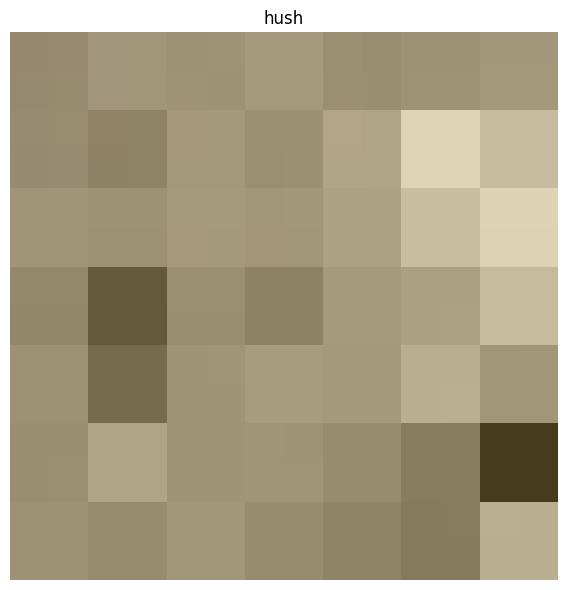

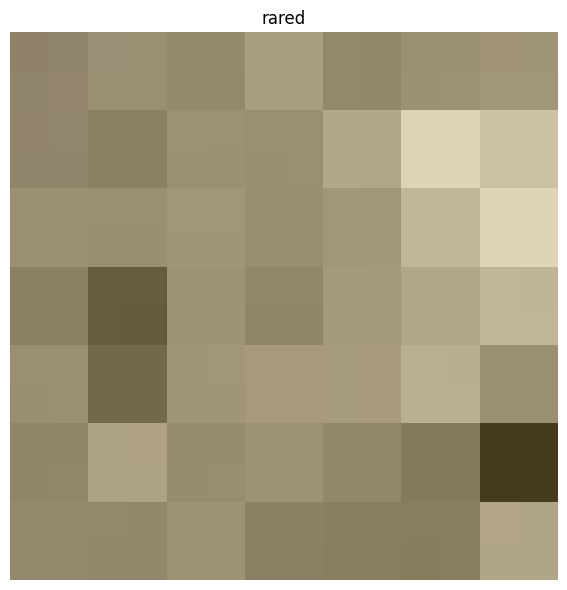

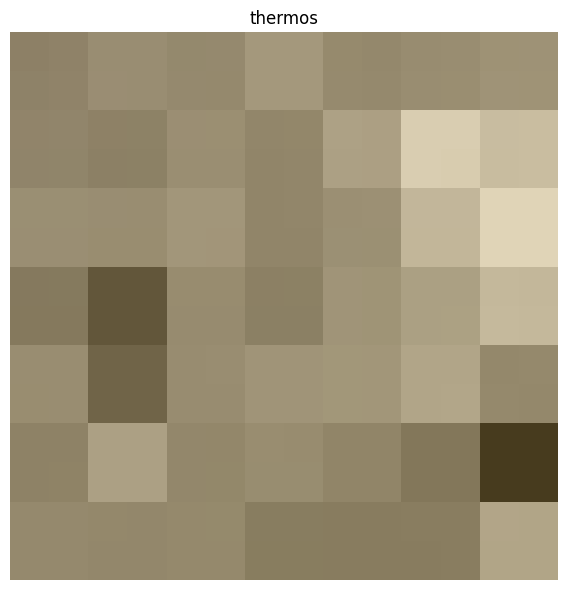

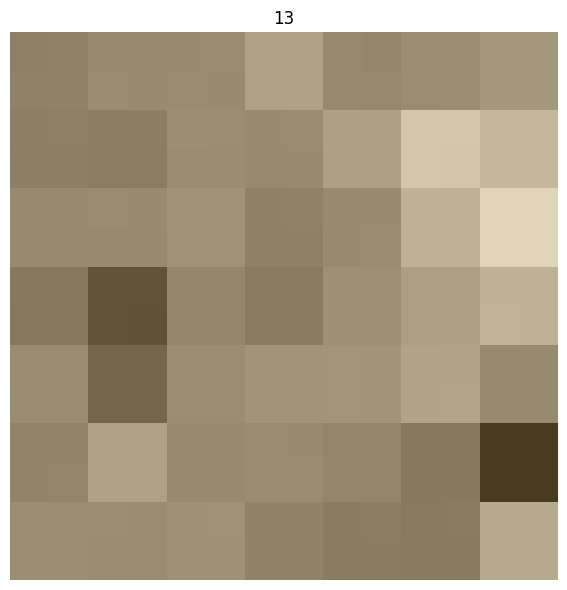

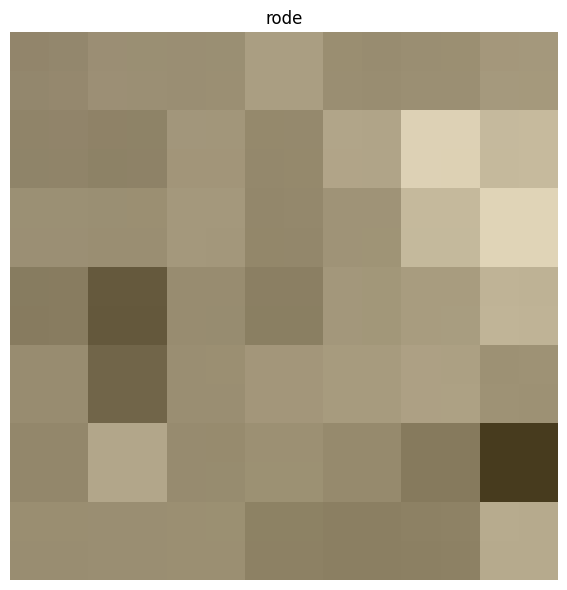

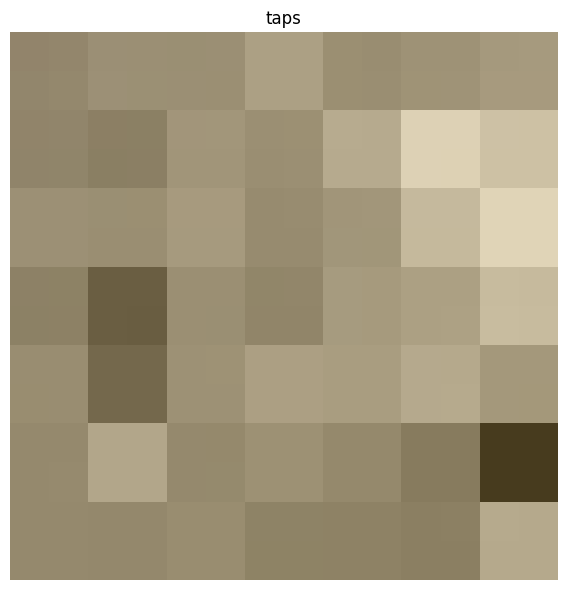

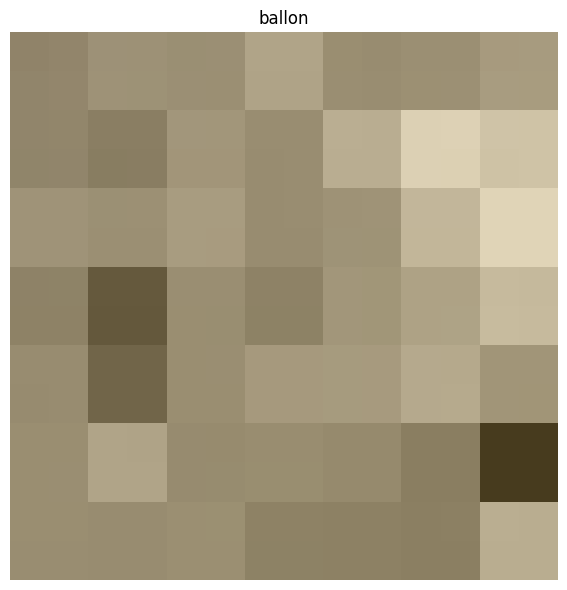

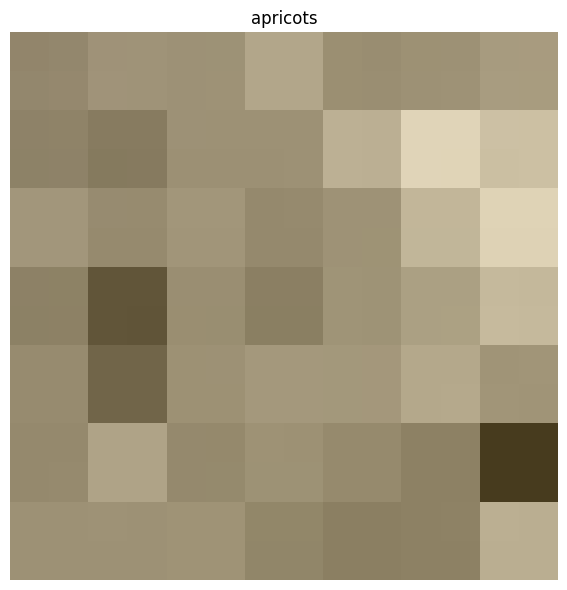

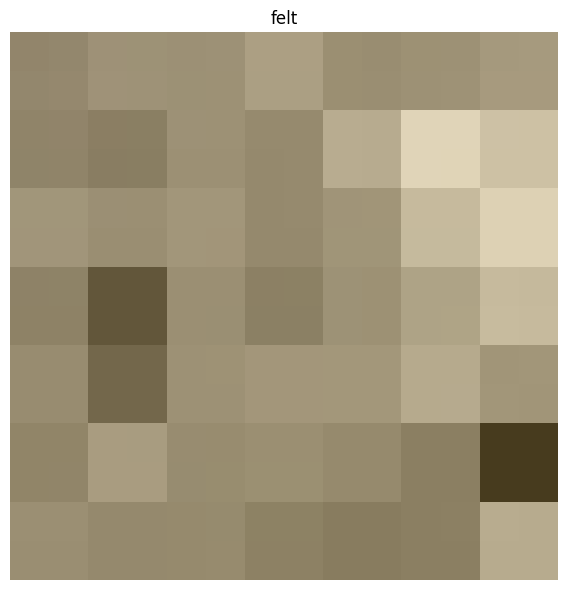

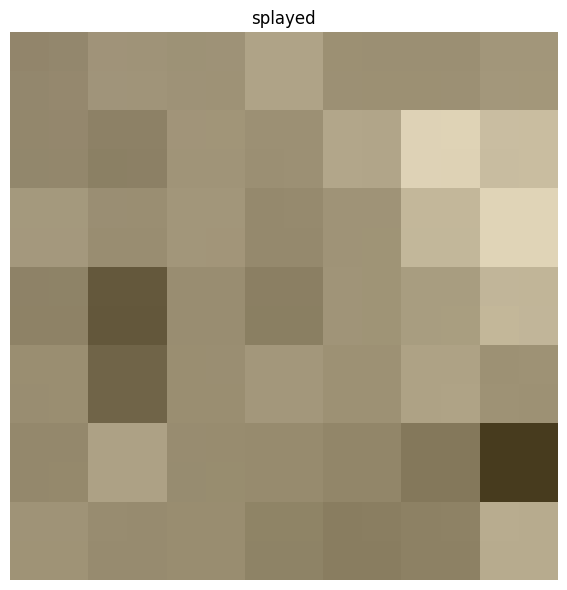

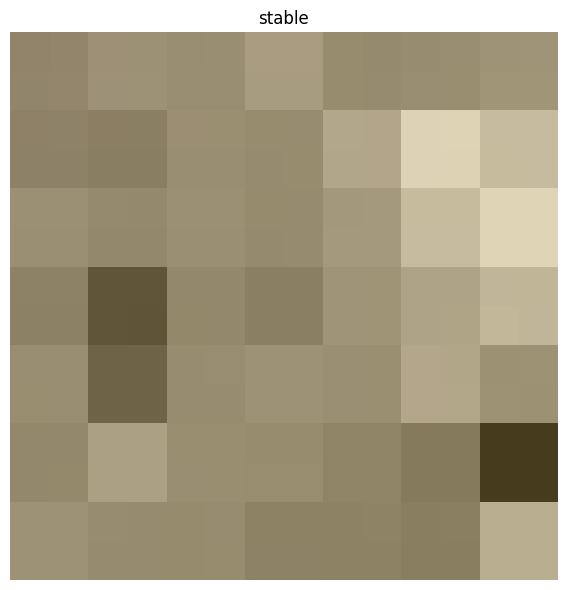

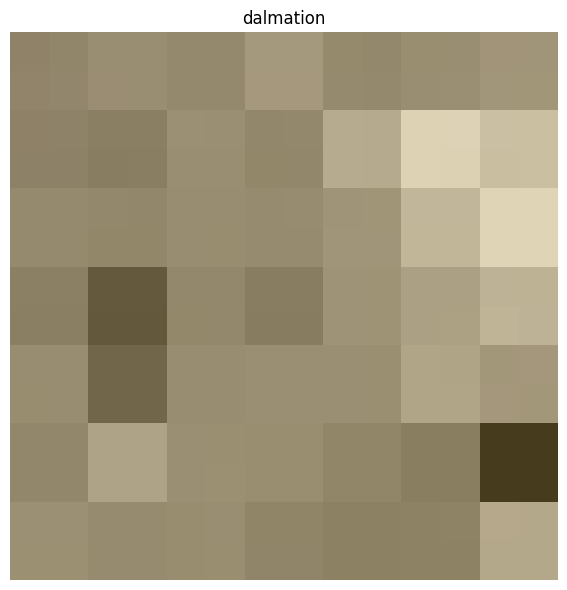

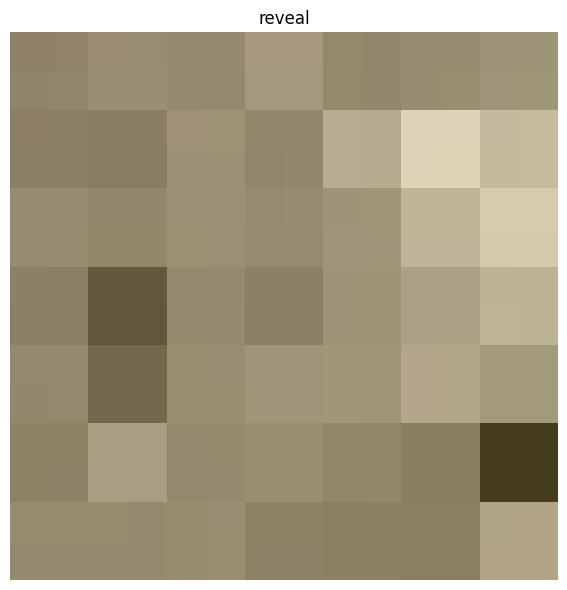

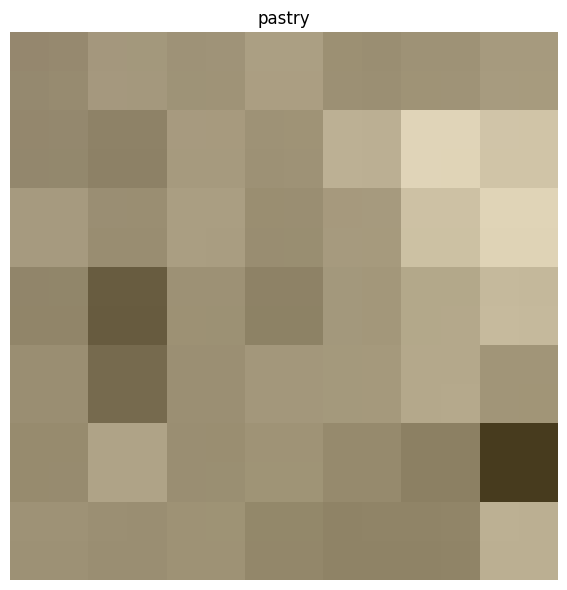

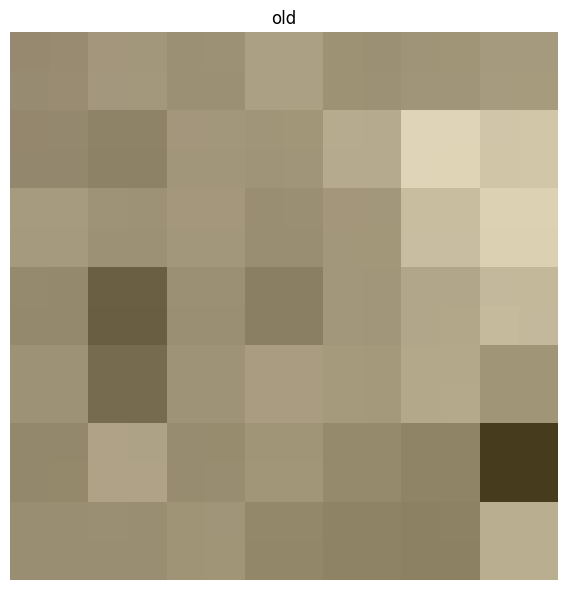

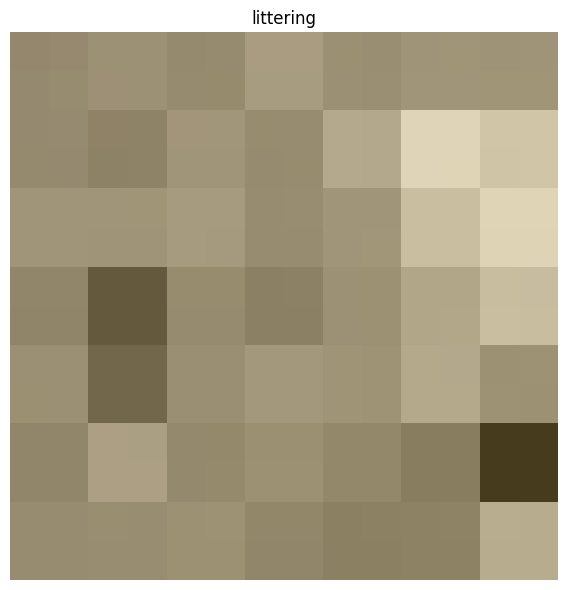

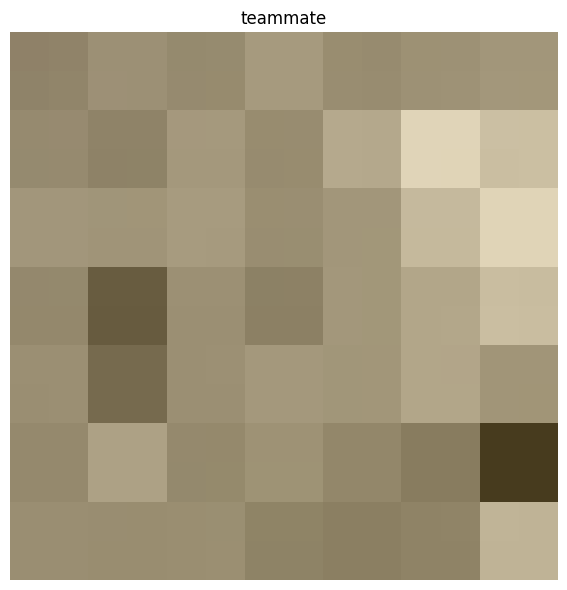

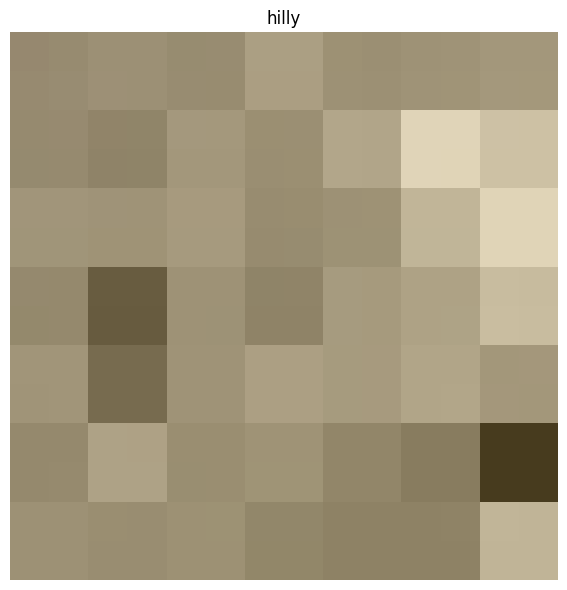

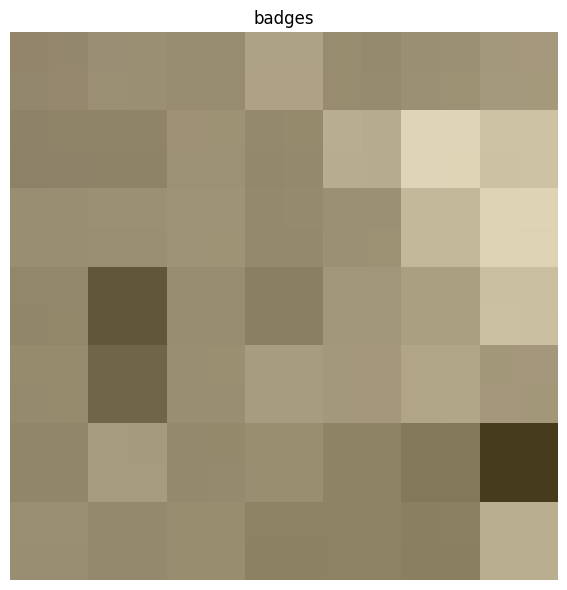

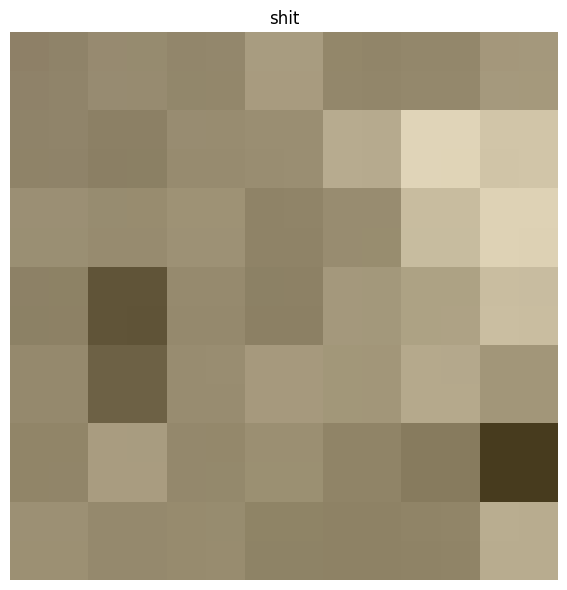

In [ ]:
from PIL import Image
# image = Image.open("./data/coco/test2017/000000000001.jpg").convert("RGB")
# image = Image.open("./data/coco/test2017/000000000016.jpg").convert("RGB")
image = Image.open("./data/coco/val2017/000000000139.jpg").convert("RGB")

def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

transform = get_transform()  # 학습 때 사용한 transform 함수
image_tensor = transform(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    encoder_out = encoder(image_tensor)
    caption, attention_weights = decoder.generate_caption(encoder_out, vocab)

print("🖼️ 생성된 캡션:", " ".join(caption))
print(len(attention_weights))  # 캡션 길이와 같아야 정상
print(attention_weights[0].shape)  # [num_pixels] 또는 [14, 14]로 reshape 가능해야 함
visualize_attention(image, caption, attention_weights)

In [136]:
from PIL import Image
# image = Image.open("./data/coco/test2017/000000000001.jpg").convert("RGB")
image = Image.open("./data/coco/test2017/000000000016.jpg").convert("RGB")

def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

transform = get_transform()  # 학습 때 사용한 transform 함수
image_tensor = transform(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    encoder_out = encoder(image_tensor)
    caption = decoder.generate_caption_beam_search(encoder_out, vocab, beam_size=3)

print("🖼️ 생성된 캡션:", " ".join(caption))

🖼️ 생성된 캡션: chested fridges combines add perimeter characters bike services tiger compass casino promotional inviting citizens hyrdant upscale beautifully bike pound orange
